In [1]:
import numpy as np


from scipy import integrate
from scipy.interpolate import interp1d

import camb

from tqdm import tqdm, trange
from astropy import constants as const

import matplotlib.pyplot as plt

In [2]:

#Fiducial cosmological parameters Planck 2018
c=const.c.value
hubble=0.6766
omegab=0.02242*pow(hubble,-2)
omegac=0.11933*pow(hubble,-2)
om0= 0.3111  #omegac+omegab
H00=100*hubble
Ass=2.14e-9
nss = 0.9665
gamma=0.545


#table of b_e and Q from doppler draft
euclid_data = np.loadtxt('snr_surveyparams.txt')
#the table from the draft  has columns z, b_e, Q
z_euclid = euclid_data[:,0]
be_euclid = interp1d(z_euclid, euclid_data[:,1])
Q_euclid = interp1d(z_euclid,  euclid_data[:,2])
ngt_euclid = interp1d(z_euclid,1e-3 * hubble**(3) * euclid_data[:,3])
vt_euclid = interp1d(z_euclid, 1e9 * (1/hubble**3) *euclid_data[:,4])
sigma_euclid = interp1d(z_euclid,(1/hubble) *  euclid_data[:,5])
#Set up the fiducial cosmology (CAMB)
pars = camb.CAMBparams()
pars.set_cosmology(H0=H00, ombh2=omegab*pow(hubble,2), omch2=omegac*pow(hubble,2),omk=0,mnu=0)
pars.set_dark_energy() #LCDM (default)
pars.InitPower.set_params(ns=nss, r=0, As=Ass)
pars.set_for_lmax(2500, lens_potential_accuracy=0);


background = camb.get_background(pars)



In [3]:
def get_SNR_on_Z(Z,damp=True,newtonian=False):

    zbin = Z
    pars.set_matter_power(redshifts=[zbin], kmax=2.0)
    pars.NonLinear = camb.model.NonLinear_none

    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=2.0, npoints = 10000)
    s8 = np.array(results.get_sigma8())

    #Pm in Mpc^3 units, at z=Z
    Pmz  =interp1d(kh*hubble, (pk[0]/pow(hubble,3)))



    #Define E(z) = H(z)/H0
    def Ez(zc):
        return np.sqrt(1-om0+om0*pow(1+zc,3))
    #Define the comoving distance
    def drdz(zp):
        return (c/H00)/Ez(zp)
    def rcom(zc):
        return sp.integrate.romberg(drdz,0,zc)

    #Define the growth function in LCDM
    def get_growth(zz):
        omz=om0*pow(1+zz,3)/(om0*pow(1+zz,3)+1-om0)
        return pow(omz,gamma)

    #Get the growth factor
    def Dg_dz(zz):
        return get_growth(zz)/(1+zz)
    def Dgz(zc):
        ans = integrate.romberg(Dg_dz, 0.0, zc)
        return np.exp(-ans)

    #Power spectrum as fn of z (alternative way of computing it- slower)
    #def Pmz(kk,zc):
    #    return pow(Dgz(zc),2)*Pmz0(kk)

    
    Hu = results.h_of_z(Z) * (1/(1 + Z))
    H0 = results.h_of_z(0)
    om_m0 = om0
    om_m = om_m0 * (H0**2/Hu**2) *(1+Z)
    f = get_growth(Z)
    df = Hu* ((1/2)*(3*om_m -4)*f - f**2 + (3/2)*om_m)
    dHu = H0**2 * (-(1/2)* (1+Z) * om_m0 + (1/(1+Z))**2 * (1-om_m0))
    ddHu = H0**2 * ( (1/2)*Hu*(1+Z)*om_m0 + (1/(1+Z))**2 * 2 * Hu * (1-om_m0) )
    chi = results.angular_diameter_distance(Z) * (1 + Z)
    cap_L = 1
    partdQ=0
    B1 = 0.9 + 0.4 * Z
    db1 = -0.4 * Hu * (1 + Z)
    B2 = -0.741 - 0.125 * Z + 0.123 * Z**2 + 0.00637 * Z**3
    b_e = be_euclid(Z)
    db_e=0
    bs = 0.0409 - 0.199 * Z - 0.0166 * Z**2 + 0.00268 * Z**3
    Q = Q_euclid(Z)
    dQ= 0
    gamma1 = Hu* (f * (b_e - 2*Q -(2*(1-Q)/(chi*Hu)) - (dHu/Hu**2)))
    gamma2 = Hu**2 * (f*(3-b_e) + (3/2)*om_m*(2+b_e - f- 4*Q - (2*(1-Q)/(chi*Hu)) - (dHu/Hu**2) ))
    partdb1 = 0
    fnl=0

    #also use fitting formulas from the draft to find V, ng, sigma
    #sigma = (5.29 - 0.249 * Z - 0.720 * Z**2 + 0.187 * Z**3)#/hubble
    #ng_euclid =0.0193 * pow(Z, -0.0282) * np.exp(-2.81 * Z) * 1e-3 * hubble**3
    #v_euclid = 8.85 * pow(Z, 1.65) * np.exp(-0.777 * Z) * 1e9 * (1/(hubble**3))

    sigma = sigma_euclid(Z)
    ng_euclid = ngt_euclid(Z)
    v_euclid = vt_euclid(Z)


    def set_beta_coeffs():
        """
            Function that relies on global variable to return beta coefficients
            from papers
        """
        beta = {}
        beta[1] = Hu**4 * ((9.0/4.0)*om_m**2 * (6- 2*f * (2*b_e - 4*Q - (4*(1-Q))/(chi*Hu) - (2*dHu)/(Hu**2)) - (2*df)/(Hu) + b_e**2 + 5*b_e - 8*b_e*Q + 4*Q + 16*Q**2 - 16*partdQ - 8*dQ/Hu + db_e/Hu + (2/(chi**2 * Hu**2))*(1-Q + 2*Q**2 - 2*partdQ)  - (2/(chi*Hu))*(3+2*b_e - 2*b_e*Q - 3*Q + 8*Q**2 - (3*dHu/Hu**2)*(1-Q) - 8*partdQ - 2*dQ/Hu) + (dHu/Hu**2)*(-7 -2*b_e + 8*Q + (3*dHu/Hu**2)) - (ddHu/Hu**3))  + ((3/2)*om_m * f)*(5 - 2*f*(4-b_e) + (2*df/Hu) + 2*b_e*(5 + ((2*(1-Q))/(chi*Hu))) - (2*db_e/Hu) - 2*b_e**2 + 8*b_e*Q - 28*Q - (14*(1-Q)/(chi*Hu)) - 3*dHu/Hu**2 + 4*(2-(1/(chi*Hu)))*(dQ/Hu) ) + ((3/2)*om_m*f**2)*(-2 + 2*f -b_e + 4*Q + (2*(1-Q)/(chi*Hu)) + (3*dHu/Hu**2) - (12/3)*fnl ) + f**2 * (12-7*b_e + b_e**2 + (db_e/Hu) + (b_e - 3)*(dHu/Hu**2)) - (3/2)*om_m*(df/Hu))
        beta[2] = Hu**4* ((9/2)*om_m**2 * (-1 + b_e - 2*Q - ((2*(1-Q))/(chi*Hu)) - (dHu/Hu**2) ) + 3*om_m*f*(-1 + 2*f -b_e + 4*Q + (2*(1-Q)/(chi*Hu)) + (3*dHu/Hu**2) )  + 3*om_m * f**2 * (-1+b_e-2*Q - ((2*(1-Q))/(chi*Hu)) - (dHu/Hu**2))  + 3*om_m*(df/Hu))
        beta[3] = Hu**3 * ((9/4)*om_m**2 *(f-2+2*Q) + (3/2)*om_m*f * (-2 -f*(-3 + f + 2*b_e - 3*Q - ((4*(1-Q))/(chi*Hu)) - (2*dHu/Hu**2)) - (df/Hu) + 3*b_e + b_e**2 - 6*b_e*Q + 4*Q + 8*Q**2 - 8*partdQ - 6*(dQ/Hu) + (db_e/Hu) + (2/(chi**2*Hu**2))*(1-Q +2*Q**2 - 2*partdQ) + (2/(chi*Hu))*(-1 -2*b_e + 2*b_e*Q + Q - 6*Q**2 + (3*dHu/Hu**2)*(1-Q) + 6*partdQ + 2*(dQ/Hu) ) - (dHu/Hu**2)*(3+2*b_e - 6*Q - (3*dHu/Hu**2)) - (ddHu/Hu**3))  + f**2 * (-3 + 2*b_e*(2+ ((1-Q)/(chi*Hu))) - b_e**2 + 2*b_e*Q - 6*Q - (db_e/Hu) - ((6*(1-Q))/(chi*Hu)) + 2*(1-(1/(chi*Hu)))*(dQ/Hu) ))
        beta[4] = (Hu**3 * ((9/2)*om_m*f * (-b_e + 2*Q +  (2*(1-Q)/(chi*Hu)) + (dHu/Hu**2))))
        beta[5] = (Hu**3 * ( 3* om_m * f * (b_e - 2*Q -(2*(1-Q)/(chi*Hu)) - (dHu/Hu**2))  ))
        beta[6] = Hu**2 * ((3/2) *om_m * (2-2*f + b_e - 4*Q - ((2*(1-Q))/(chi*Hu)) - (dHu/Hu**2)))
        beta[7] = Hu**2*(f*(3-b_e))
        beta[8]= Hu**2*(3*om_m*f*(2-f-2*Q) + f**2 * (4 + b_e - b_e**2 + 4*b_e*Q - 6*Q - 4*Q**2 + 4*partdQ + 4*(dQ/Hu) -(db_e/Hu) - (2/(chi**2 * Hu**2))*(1-Q+2*Q**2 - 2*partdQ) - (2/(chi*Hu))*(3-2*b_e + 2*b_e*Q - Q - 4*Q**2 + ((3*dHu)/(Hu**2))*(1-Q) + 4*partdQ + 2*(dQ/Hu)) - (dHu/Hu**2)*(3-2*b_e+4*Q+((3*dHu)/(Hu**2))) + (ddHu/Hu**3)))
        beta[9] = (Hu**2 * ( -(9/2)*om_m*f ))
        beta[10] = (Hu**2 * (3 * om_m * f))
        beta[11] = Hu**2 * (3*om_m*(1+f) + 2*f - f**2*(-1+b_e-2*Q - ((2*(1+Q))/(chi*Hu)) - (dHu/Hu**2)))
        beta[12] = Hu**2*((3/2)*om_m * (-2 + B1 * (2+b_e-4*Q - ((2*(1-Q))/(chi*Hu)) - (dHu/Hu**2)) + (db1/Hu) + 2*(2-(1/(chi*Hu)))*partdb1) - f*(2+ B1*(f-3+b_e) + (db1/Hu)))
        beta[13] = ( (9.0/4.0)*om_m**2.0*Hu**2.0 )+ ( 1.5*om_m*f*Hu**2.0*(-(2.0*f)+(2.0*b_e)-(6.0*Q) -((4.0*(1.0-Q))/(chi*Hu)) -((3.0*dHu)/Hu**2.0) ) )+ ( f**2.0*Hu**2.0*(5.0-b_e) )
        beta[14] = Hu* ( -(3/2)*om_m*B1 )
        beta[15] = Hu*2*f**2
        beta[16] = Hu*(f*(B1 * (f+b_e-2*Q - ((2*(1-Q))/(chi*Hu)) - (dHu/Hu**2)) + (db1/Hu) + 2*(1- (1/(chi*Hu)))*partdb1 ))
        beta[17] = Hu*(-(3/2)*om_m*f)
        beta[18] = Hu* ( (3/2)*om_m*f - f**2 * (3 - 2*b_e + 4*Q + ((4*(1-Q))/(chi*Hu)) + (3*dHu/Hu**2)) )
        beta[19] = Hu * (f* (b_e - 2*Q - ((2*(1-Q))/(chi*Hu)) - (dHu/Hu**2)))

        return beta



    #power spectrum at redshift Z
    def Pm(i,k):
        kk = k[i]
        return Pmz(kk)



    #k = {1:k1,2:k2,3:k3,"theta":theta}
    #mu = {1:mu1,2:mu2,3:mu3}

    # def get_mus(self,MU_1,PHI,k):
    #     mu = {1:MU_1}
    #     mu[2]=mu[1]*np.cos(k["theta"]) + np.sqrt(1.0-mu[1]**2) * np.sin(k["theta"])*np.cos(PHI)
    #     mu[3] = - (k[1] / k[3]) * mu[1] - (k[2] / k[3]) * mu[2]
    #     return mu


    class NotATriangle(Exception):
        pass

    def get_theta(k1,k2,k3):
        x = 0.5 * (k3**2 - (k1**2 + k2**2))/(k1 * k2)
        if x>1 or x<-1:
            raise NotATriangle()
        return np.arccos(x)

    def get_mus(MU_1,PHI,k):
        mu = {1:MU_1}
        mu[2]=mu[1]*np.cos(k["theta"]) + np.sqrt(1.0-mu[1]**2) * np.sin(k["theta"])*np.cos(PHI)
        mu[3] = - (k[1] / k[3]) * mu[1] - (k[2] / k[3]) * mu[2]
        return mu


    def get_cosinus(i,j,k):
        perms = [1,2,3]
        assert i!=j
        assert i in perms
        assert j in perms
        perms.remove(i)
        perms.remove(j)
        l = perms[0]

        return 0.5 * (k[l]**2 - k[i]**2 - k[j]**2) / (k[i] * k[j])

    #doppler snr: only O(1/k) corrections included

    def E(i,j,l,k):
        cosinus = get_cosinus(i,j,k)
        return ((k[i]**2 * k[j]**2) / (k[l]**4) ) * (3 + 2 * cosinus * (k[i]/k[j] + k[j]/k[i]) + cosinus**2  )

    def F(i,j,l,k):
        cosinus = get_cosinus(i,j,k)
        return 10/7 + cosinus * (k[i]/k[j] + k[j]/k[i]) + (1 - 3/7) * cosinus**2

    def G(i,j,l,k):
        cosinus = get_cosinus(i,j,k)
        return 6/7 + cosinus * (k[i]/k[j] + k[j]/k[i]) + (2 - 6/7) * cosinus**2

    def KN1(i,mu,B1,f):
        return B1 + f * mu[i]**2

    def KGR1(i,mu,k,gamma1,gamma2):
        return (gamma1/k[i])*1j*mu[i]

    def KN2(i,j,l,k,mu,B1,B2,f):
        cosinus = get_cosinus(i,j,k)
        F_f = F(i,j,l,k)
        G_f = G(i,j,l,k)
        p1 = B1 * F_f + B2 + f * G_f * mu[l]**2
        p2 = bs * (cosinus**2 - 1/3)
        p3 = f**2 * (mu[i] * mu[j])/(k[i] * k[j]) * (mu[i] * k[i] + mu[j] * k[j])**2
        p4 = B1 * f/(k[i] * k[j]) * ((mu[i]**2 + mu[j]**2) * k[i] * k[j] + mu[i] * mu[j] * (k[i]**2 + k[j]**2))
        return p1 + p2 + p3 + p4


    def KGR2(i,j,l,k,mu,beta):
        cosinus = get_cosinus(i,j,k)
        E_f = E(i,j,l,k)
        F_f = F(i,j,l,k)
        G_f = G(i,j,l,k)
        k_prod = k[i]**2 * k[j]**2
        #p1 = beta[1] + E_f * beta[2]
        #p2 = 1j* ((mu[i] * k[i] + mu[j] * k[j]) * beta[3] + mu[l] * k[l] * (beta[4] + E_f * beta[5]) )
        #p3 = k_prod/(k[l]**2) * (F_f * beta[6] + G_f * beta[7]) + (mu[i] * k[i] * mu[j] * k[j])*beta[8]
        #p4 = mu[l]**2 * k[l]**2 * (beta[9] + E_f * beta[10]) + (k[i] * k[j] * cosinus) * beta[11]
        #p5 = (k[i]**2 + k[j]**2) * beta[12] + (mu[i]**2 * k[i]**2 + mu[j]**2 * k[j]**2) * beta[13]
        p_comp1 = (mu[i] * k[i]**3 + mu[j] * k[j]**3) * beta[14]
        p_comp2 = (mu[i] * k[i] + mu[j] * k[j]) * k[i] * k[j] * cosinus * beta[15]
        p_comp3 = k[i] * k[j] * (mu[i] * k[j] + mu[j] * k[i]) * beta[16]
        p_comp4 = (mu[i]**3 * k[i]**3 + mu[j]**3 * k[j]**3) * beta[17]
        p_comp5 = mu[i] * mu[j] * k[i] * k[j] * (mu[i] * k[i] + mu[j] * k[j]) * beta[18]
        p_comp6 = mu[l] * k_prod/k[l] * G_f * beta[19]
        #real = p1 + p2 + p3 + p4 + p5
        comp = p_comp1 + p_comp2 + p_comp3 + p_comp4 + p_comp5 + p_comp6
        return  (1/k_prod) * (1j * comp)



    def B_perm(i,j,l,k,mu,B1,B2,gamma1,gamma2,beta,f):
        if newtonian:
            return KN1(i,mu,B1,f) * KN1(j,mu,B1,f) * KN2(i,j,l,k,mu,B1,B2,f) * Pm(i,k) * Pm(j,k)
        else:

            T1 = KGR1(i,mu,k,gamma1,gamma2) * KN1(j,mu,B1,f) *  KN2(i,j,l,k,mu,B1,B2,f)
            T2 = KGR1(j,mu,k,gamma1,gamma2) * KN1(i,mu,B1,f) *  KN2(i,j,l,k,mu,B1,B2,f)
            T3 = KN1(i,mu,B1,f) * KN1(j,mu,B1,f) * KGR2(i,j,l,k,mu,beta)
            return (T1 + T2 + T3) * Pm(i,k) * Pm(j,k)

    def B_full(k,mu,B1,B2,gamma1,gamma2,beta,f):
        if damp:
            damp_term = np.exp(- (1/2) * (k[1]**2 * mu[1]**2 + k[2]**2 * mu[2]**2 + k[3]**2 * mu[3]**2) * sigma**2)
        else:
            damp_term = 1
        return  (B_perm(1,2,3,k,mu,B1,B2,gamma1,gamma2,beta,f) + B_perm(1,3,2,k,mu,B1,B2,gamma1,gamma2,beta,f) + B_perm(2,3,1,k,mu,B1,B2,gamma1,gamma2,beta,f)) * damp_term

    def P_twiddle(i,k,mu,B1,f):
        return KN1(i,mu,B1,f)**2 * Pm(i,k) *  np.exp(- (1/2) * ((k[i] * mu[i] * sigma)**2)) + (1/ng_euclid)

    def P_galaxy(i,k,mu,B1,f):
        return KN1(i,mu,B1,f)**2 * Pm(i,k) *  np.exp(- (1/2) * ((k[i] * mu[i] * sigma)**2))

    def s_B(k):
        if (k[1]==k[2] and k[2]==k[3]):
            return 6
        elif (k[1]==k[2] or k[1]==k[3] or k[2]==k[3]):
            return 2
        else:
            return 1


    def arr_func(k,mu1,phis):
        mu = get_mus(mu1,phis,k)
        bisp = B_full(k,mu,B1,B2,gamma1,gamma2,beta,f)
        varb_num = np.pi * kf**3 * mu_range * phi_range * P_twiddle(1,k,mu,B1,f) * P_twiddle(2,k,mu,B1,f) * P_twiddle(3,k,mu,B1,f)
        varb_den = k[1] * k[2] * k[3] * (deltak)**3 * deltamu * deltaphi
        res = (abs(bisp)**2) * varb_den / varb_num
        return res.sum()

    

    #beta coeffs
    beta = set_beta_coeffs()
    kf = (2 * np.pi) / pow(v_euclid, 1/3)
    deltamu = 0.04
    deltaphi = np.pi/25
    mu_range = 2.0
    phi_range = 2 * np.pi
    deltaz = 0.1
    #n_s from Planck best fit 2018:
    n_s = 0.9665
    kmin = kf
    kmax = 0.15 * hubble #0.1 * hubble * pow((1 + Z),(2/(2 + n_s)) )  #0.15*hubble
    deltak =  kf
    mu_bins = np.arange(-1,1,deltamu)
    phi_bins = np.arange(0,2*np.pi,deltaphi)
    mu1 = np.tile(mu_bins,(50,1))
    phis = np.tile(phi_bins,(50,1)).T

    
    snr=0.0

    klist=[]
    
    k_bins = np.arange(kmin,kmax,deltak)
    
    for k1 in k_bins:
        for k2 in k_bins[k_bins<=k1]:
            for k3 in k_bins[k_bins<=k2]:  #k3_bins[k3_bins<=k2]:
                try:
                    k = {1:k1, 2:k2, 3:k3, "theta":get_theta(k1,k2,k3)}
                    klist.append(k)
                except NotATriangle:
                    continue
    for k in tqdm(klist):
        snr += arr_func(k,mu1,phis)

    return np.sqrt(snr)


In [6]:
newt_snrs_damp = []
    #newt_snrs_nodamp = []
for Z in np.arange(0.7,2.1,0.1):
        #newt_snrs_nodamp += [get_SNR_on_Z(Z,damp=False,newtonian=True)]
    newt_snrs_damp += [get_SNR_on_Z(Z,damp=True,newtonian=True)]

100%|██████████| 8756/8756 [00:08<00:00, 988.68it/s] 


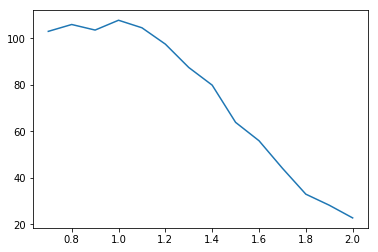

In [7]:
plt.plot(np.arange(0.7,2.1,0.1),newt_snrs_damp,label='SNR- damp - B_newt')